## Fine-tuning Pretrained model ##

Based on pytorch's tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

All models: https://pytorch.org/vision/stable/models.html

In [36]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Here you should test augmenting the data!! ##

#### Augment the hymenoptera dataset with different transformations ####
#### Augment the Mario level img cutting, rotating, and such on to create a dataset out of it ####

In the report, reflect about how the transformations and data augmentation work!

In [53]:
data_dir = '../1-computer-vision-lab/mario'

transformMario = {transforms.Compose([
    transforms.RandomCrop(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])}
imageData = datasets.ImageFolder(os.path.join(data_dir), transformMario)
dataset = torch.utils.data.DataLoader(imageData)

In [54]:
# Data is transformed to have variation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

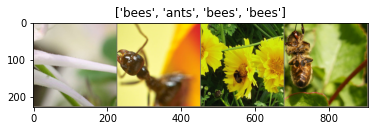

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train and test loop ##

In [4]:
def train_model(model, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']

    print('train Loss: {:.4f} Acc: {:.4f}'.format(
         epoch_loss, epoch_acc))

In [5]:
def test_model(model, criterion):
    since = time.time()
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [55]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

### This way we are going to create a new final layer but retrian the whole network!! ###

In [56]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features # Get what the final layer should receive

# Here the size of each output sample is set to 2 (the class names)
# Create a new final layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

In [57]:
num_epochs = 4

criterion = nn.CrossEntropyLoss()

# We are optimizing
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print()
    train_model(model_ft, criterion, optimizer_ft)
    test_model(model_ft, criterion)
    scheduler.step()

Epoch 0/3

train Loss: 0.8558 Acc: 0.5265
test Loss: 0.8494 Acc: 0.4510
Epoch 1/3

train Loss: 0.8287 Acc: 0.5429
test Loss: 0.7816 Acc: 0.5556
Epoch 2/3

train Loss: 0.8663 Acc: 0.5959
test Loss: 1.0967 Acc: 0.5490
Epoch 3/3

train Loss: 0.9047 Acc: 0.5796
test Loss: 0.7593 Acc: 0.5752


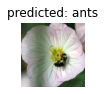

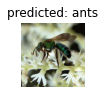

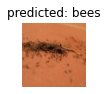

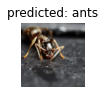

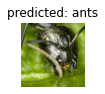

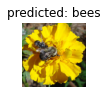

In [58]:
visualize_model(model_ft)

## Now you need to freeze the network and replace the last layer as we did before ##

In [64]:
#x is number of classes (outputs), i don't really know what we are supposed to replace the last layer with, we only have 2 classes in the data
x = 10
modelFrozen = model_ft
numFeaturesIn = modelFrozen.fc.in_features
modelFrozen.fc = nn.Linear(num_ftrs, x)
modelFrozen = modelFrozen.to(device)

optimizer_ft = optim.SGD(modelFrozen.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print()
    train_model(modelFrozen, criterion, optimizer_ft)
    test_model(modelFrozen, criterion)
    scheduler.step()

Epoch 0/3

train Loss: 1.0360 Acc: 0.5224
test Loss: 0.9146 Acc: 0.5752
Epoch 1/3

train Loss: 0.8777 Acc: 0.5633
test Loss: 0.8037 Acc: 0.6209
Epoch 2/3

train Loss: 0.8745 Acc: 0.5633
test Loss: 0.9414 Acc: 0.5752
Epoch 3/3

train Loss: 0.8456 Acc: 0.5347
test Loss: 0.7063 Acc: 0.5817


## Now you should create your own nn.Module() as we have seen before, reconstruct the layers, and (if wanted) copy the weights ##

This way, you will be able to do other operations with the same structure (perhaps you want to drop some layer, apply another activation function, apply a deconvnet, add some extra calculations in the forward pass, etc.)

In [69]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

class MyAlexnet (nn.Module):
    def __init__(self):
        super(MyAlexnet, self).__init__()
        #self.conv1 = nn.Conv2d(3,64,kernel_size=(11, 11),stride=(4,4),padding=(2,2))
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d( (6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5,inplace = False),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5,inplace = False),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, out_features=1000, bias=True),
        )
    def forward(self, inputs):
        x = self.features(inputs)
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)# ithink this is where the flatten goes
        
        x = self.classifier(x)
        return x
myAlex = MyAlexnet()
print(myAlex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [62]:
print(model_ft)
test = models.resnet18(pretrained=True)
print(test)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  